<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/Pairing%20CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
!pip install ortools
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt # Data visualization
import random
import numpy as np

In [31]:
team_members = [tm for tm in range(20)]
tasks = [t for t in range(10)]


duration = {task:3*random.randint(1,10)
           for task in tasks}
random.seed(1)
costs = [ [random.randint(20,100) for t in tasks]
        for tm in team_members
]
costs, duration, sum(duration.values())/len(team_members)

def generate_unique_pairs(activities, num_pairs):
    if num_pairs * 2 > len(activities):
        raise ValueError("Not enough activities to create unique pairs.")
    random.shuffle(activities)
    return [activities[i:i+2] for i in range(0, num_pairs * 2, 2)]

# Example usage
num_pairs = 3
unique_pairs = generate_unique_pairs(tasks, num_pairs)
print(unique_pairs)
print(tasks)
costs

[[7, 1], [9, 3], [2, 4]]
[7, 1, 9, 3, 2, 4, 5, 6, 0, 8]


[[37, 92, 28, 52, 35, 83, 77, 80, 68, 46],
 [32, 82, 23, 69, 75, 97, 20, 77, 54, 49],
 [95, 33, 60, 23, 22, 23, 89, 21, 68, 47],
 [74, 23, 87, 48, 76, 83, 90, 49, 64, 49],
 [48, 78, 57, 22, 73, 91, 32, 43, 100, 57],
 [35, 62, 84, 74, 84, 44, 58, 56, 95, 83],
 [84, 70, 95, 24, 81, 51, 71, 73, 42, 66],
 [90, 67, 31, 76, 85, 33, 40, 86, 70, 67],
 [82, 23, 80, 25, 59, 98, 95, 94, 70, 41],
 [41, 84, 49, 21, 45, 89, 90, 49, 71, 85],
 [64, 93, 65, 78, 54, 90, 97, 20, 69, 85],
 [36, 86, 91, 46, 74, 27, 81, 66, 92, 90],
 [45, 84, 72, 82, 65, 73, 64, 20, 88, 89],
 [99, 98, 62, 78, 96, 23, 49, 42, 90, 94],
 [43, 31, 90, 52, 24, 29, 30, 22, 77, 21],
 [55, 51, 54, 34, 99, 43, 64, 57, 28, 41],
 [40, 52, 87, 41, 54, 57, 78, 61, 83, 80],
 [34, 23, 59, 69, 63, 73, 44, 53, 33, 52],
 [85, 46, 97, 75, 22, 48, 22, 70, 38, 24],
 [40, 77, 84, 74, 89, 48, 100, 86, 77, 48]]

In [32]:
duration

{0: 9, 1: 12, 2: 3, 3: 15, 4: 6, 5: 6, 6: 15, 7: 15, 8: 9, 9: 21}

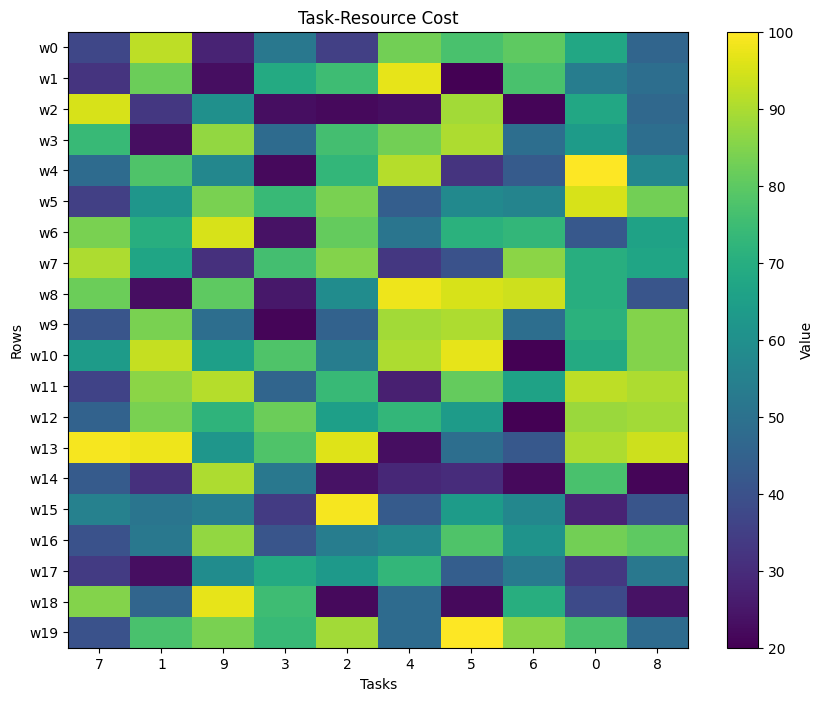

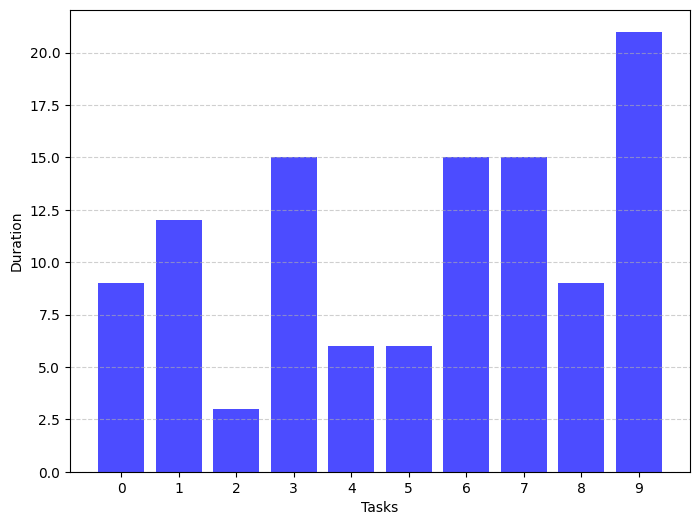

In [33]:
data_array = np.array(costs)

plt.figure(figsize=(10, 8))
plt.imshow(data_array, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title("Task-Resource Cost")
plt.xlabel("Tasks")
plt.ylabel("Rows")
plt.xticks(range(len(tasks)), tasks)
plt.yticks(range(len(team_members)), [f"w{t}" for t in team_members] )
plt.show()

keys = list(duration.keys())
values = list(duration.values())

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(keys, values, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel("Tasks")
plt.ylabel("Duration")
plt.xticks(keys)  # Ensure all keys are displayed as x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [34]:
for (t1,t2) in unique_pairs:
  print(t1,t2, duration[t1]+duration[t2])

7 1 27
9 3 36
2 4 9


In [39]:
"""Solves a simple assignment problem."""
def main() -> None:
    # Data
    model = cp_model.CpModel()
    # Variables
    x = {}
    for worker in team_members:
        for task in tasks:
            x[worker, task] = model.NewBoolVar(f"x[{worker},{task}]")

    for task in tasks:
        model.AddExactlyOne([x[tm, task] for tm in team_members])

    for tm in team_members:
        model.Add(sum([duration[task]*x[tm, task] for task in tasks] ) <= 100)


    coupled = {}
    for tm1 in team_members:
        for tm2 in team_members:
            if tm1 > tm2:
              coupled[tm1,tm2] = model.NewBoolVar(f"coupled[{tm1},{tm2}]")


    for (task1,task2) in unique_pairs:
      tm1 = sum([tm*x[tm, task1] for tm in team_members])
      tm2 = sum([tm*x[tm, task2] for tm in team_members])
      model.Add(tm1!=tm2)
      for tm1 in team_members:
        for tm2 in team_members:
          if tm1 != tm2:
            if tm1>tm2:
              model.Add(coupled[tm1,tm2]>= x[tm1, task1]+x[tm2, task2]-1)
            else:
              model.Add(coupled[tm2,tm1]>= x[tm1, task1]+x[tm2, task2]-1)




    print(len(coupled))



    # Objective
    objective_terms = []
    for worker in team_members:
        for task in tasks:
            objective_terms.append(costs[worker][task] * x[worker, task])

    term2 = [v for (tm1,tm2),v in coupled.items()]
    model.minimize(sum(objective_terms) + 100*sum(term2) )

    # Solve
    solver = cp_model.CpSolver()
    status = solver.solve(model)

    # Print solution.
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print(f"Total cost = {solver.objective_value}\n")
        for worker in team_members:
            for task in tasks:
                if solver.value(x[worker, task]):
                    print(
                        f"Worker {worker} assigned to task {task} du {duration[task]}."
                        + f" Cost = {costs[worker][task]}")

        for (task1,task2) in unique_pairs:
          tm1 = sum([tm*solver.value(x[tm, task1]) for tm in team_members])
          tm2 = sum([tm*solver.value(x[tm, task2]) for tm in team_members])
          #model.Add(tm1!=tm2)

        for (tm1,tm2),v in coupled.items():
          if solver.value(v):
            print('TAG100',tm1,tm2)
        for (t1,t2) in unique_pairs:
          tm1 = sum([tm*solver.value(x[tm, t1]) for tm in team_members])
          tm2 = sum([tm*solver.value(x[tm, t2]) for tm in team_members])
          print("Coupled", t1,t2, tm1,tm2)

        time = solver.value(sum(objective_terms))
        term2 = sum([solver.value(v) for (tm1,tm2),v in coupled.items()])
        print(time, term2)
        return solver, x, coupled

    else:
        print("No solution found.")


if __name__ == "__main__":
    solver, x, coupled = main()

190
Total cost = 383.0

Worker 1 assigned to task 6 du 15. Cost = 20
Worker 1 assigned to task 0 du 9. Cost = 32
Worker 2 assigned to task 7 du 15. Cost = 21
Worker 2 assigned to task 3 du 15. Cost = 23
Worker 2 assigned to task 2 du 3. Cost = 60
Worker 13 assigned to task 5 du 6. Cost = 23
Worker 14 assigned to task 1 du 12. Cost = 31
Worker 14 assigned to task 9 du 21. Cost = 21
Worker 14 assigned to task 4 du 6. Cost = 24
Worker 15 assigned to task 8 du 9. Cost = 28
TAG100 14 2
Coupled 7 1 2 14
Coupled 9 3 14 2
Coupled 2 4 2 14
283 1


In [36]:
tasks
[1.5*tasks.index(task) for task in tasks]

[0.0, 1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5, 12.0, 13.5]

10 10


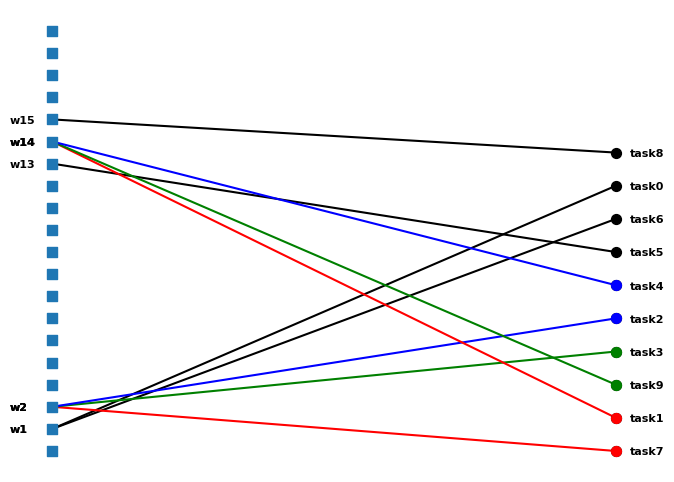

In [40]:
KOLORS  = [
    "red", "green", "blue", "orange", "purple", "cyan", "magenta",
    "yellow", "lime", "pink", "brown", "gray", "olive", "navy", "teal"]

X = [1 for tm in team_members]
Y = [tm for tm in team_members]

X2 = [5 for task in tasks]
Y2 = [1.5*task for task in tasks]

plt.figure(figsize=(8,6))
plt.scatter(X,Y, s= 50 , marker = 's')
plt.scatter(X2,Y2, s= 50, c= 'k')
print(len(Y2),len(X2))

for (worker,task), v in x.items():
  if solver.value(v)>0:
    x0,y0= X[worker],Y[worker]
    x1,y1= X2[task],1.5*tasks.index(task)
    kk='k'
    for counter in range(len(unique_pairs)):
      if task in unique_pairs[counter]:
        kk = KOLORS[counter]

    plt.plot([x0,x1],[y0,y1], zorder = -2, c=kk)
    plt.text(x0-0.3,y0-0.2, f"w{worker}", fontsize = 8, fontweight ='bold')
    plt.text(x1+0.1,y1-0.2, f"task{task}", fontsize = 8, fontweight ='bold')

counter = 0
for (task1,task2) in unique_pairs:
  x0,y0 = X2[task1],1.5*tasks.index(task1)
  x1,y1 = X2[task2],1.5*tasks.index(task2)
  plt.scatter(x0,y0, s= 50, c= KOLORS[counter])
  plt.scatter(x1,y1, s= 50, c= KOLORS[counter])
  counter+=1

plt.axis('off')
plt.show()


In [38]:
[[12, 19], [2, 7], [17, 0], [10, 4], [16, 18], [9, 3]]


[[12, 19], [2, 7], [17, 0], [10, 4], [16, 18], [9, 3]]